# CellRank meets real time

In this tutorial, you will learn how to...

- match cells across experimental time points using moscot's TemporalProblem (CITE). 
- set up CellRank's TransportMapKernel (REF) to combine transitions within- and across time-points. 
- visualize these transitions in a low dimensional embedding. 

To demonstrate the appproach in this tutorial, we use XXX

<img src="_static/img/moscot_to_cellrank.jpg" width=800  alt="Moscot and CellRank interface to analyze dynamics in complex spatio-temporal datasets. ">

<div class="alert alert-info">
Important

If you want to run this on your own data, you will need...

- a scRNA-seq dataset with experimental time points. Additional spatial- or lineage information improves the accuracy of fate mapping, but is not required. 

</div>

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/cellrank_meets_real_time.ipynb).

## Import packages & data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [3]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import pandas as pd
from moscot.problems.time import TemporalProblem
from cellrank.kernels import TransportMapKernel
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

Global seed set to 0


In [4]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

Read AnnData object from disk (or download). 

In [5]:
adata = cr.datasets.reprogramming_schiebinger()
adata

AnnData object with n_obs × n_vars = 236285 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

This data contains cells cultured in both 2i as well as serum conditions - we’ll focus on the serum condition here.

In [6]:
adata = adata[adata.obs["serum"] == "True"].copy()

Experimental time points are saved in `adata.obs["day"]` as categoricals. Let's convert the categories to be numerical, this is required by moscot later on. 

In [7]:
adata.obs["day"] = adata.obs["day"].cat.rename_categories({day: float(day) for day in adata.obs["day"].cat.categories})

In addition, it's nicer for plotting to have numerical values. 

In [8]:
adata.obs["day_numerical"] = adata.obs["day"].astype(float)

Subsample to speed up the analysis - this tutorial is meant to run in a couple of minutes on a laptop. It’s not a problem for CellRank to do any of the computations here on the full data, we’d just have to wait a bit longer.

In [9]:
sc.pp.subsample(adata, fraction=0.25, random_state=0)
adata

AnnData object with n_obs × n_vars = 41473 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch', 'day_numerical'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

## Visualize embedding

Let’s visualize this data, using the original force-directed layout (CITE). 

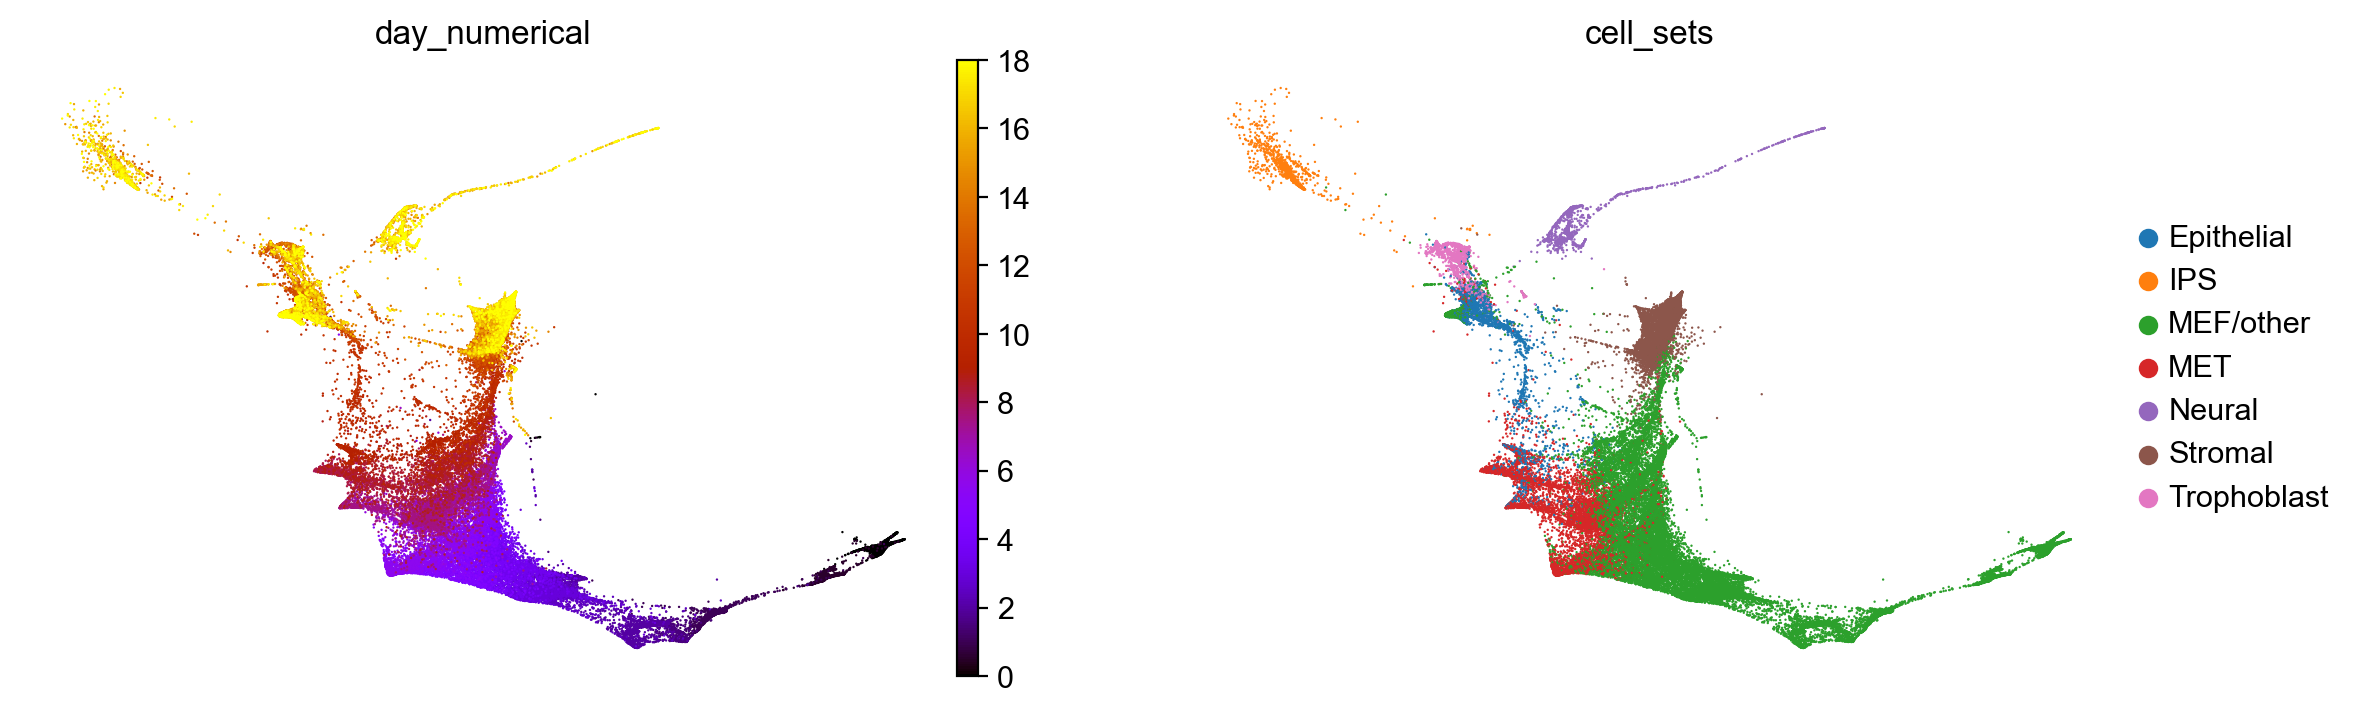

In [10]:
sc.pl.embedding(adata, basis="force_directed", color=["day_numerical", "cell_sets"], color_map="gnuplot", frameon=False)

Each dot is a cell in the force-direction embedding, colored according to one of the 39 time-points of sequencing, from early (day 0, in black) to late (day 18, in yellow) (left) or simplified cell-set annotations (right). 

## Pre-process the data

This datset has already been normalized by total counts and log2-transformed. Further, highly variable genes have already been annotated. We can thus direclty compute PCA and a KNN graph, which we'll need for later. 

In [11]:
sc.pp.pca(adata)

In [12]:
sc.pp.neighbors(adata, random_state=0)

## Run moscot to couple cells

With [moscot](https://moscot-tools-org), we couple cells across time points using [Optimal Transport](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)) (OT), as pioneered by [Waddington OT](https://broadinstitute.github.io/wot/) (CITE). moscot scales to millions of cells and supports multi-modal data (CITE). We demonstrate the most basic use-case here: linking a smaller-scale uni-modal scRNA-seq dataset across experimental time points. To learn more, see the corresponding moscot tutorial (REF). 

<div class="alert alert-info">
Important

moscot can do much more! To learn how to incorporate multi-modal information, millions of cells, and additional spatial information, check out https://moscot-tools.org for the documentation, including many tutorials. Additionally, to include lineage-traced data, check out moscot-lineage ([moslin](https://github.com/theislab/moslin)). 
    
Importantly, everything we demonstrate here works exactly the same if you include these additional data modalities! The couplings just get better, and additional downstream analysis becomes available. 

</div>

The first step is to set up moscot's TemporalProblem (REF). If you have additional spatial or linegae information, you have to use a different moscot problem class. See the [documentation](https://moscot-tools-org) to learn more. 

In [13]:
tp = TemporalProblem(adata)

Next, we adjust the marginals for cellular growth- and death. Again, see the moscot [documentation](https://moscot-toole.org) or [preprint](https://www.biorxiv.org/content/10.1101/2023.05.11.540374v2) to learn more about this. 

In [14]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

Visualilze the computed proliferation and apoptosis scores in the embedding. 

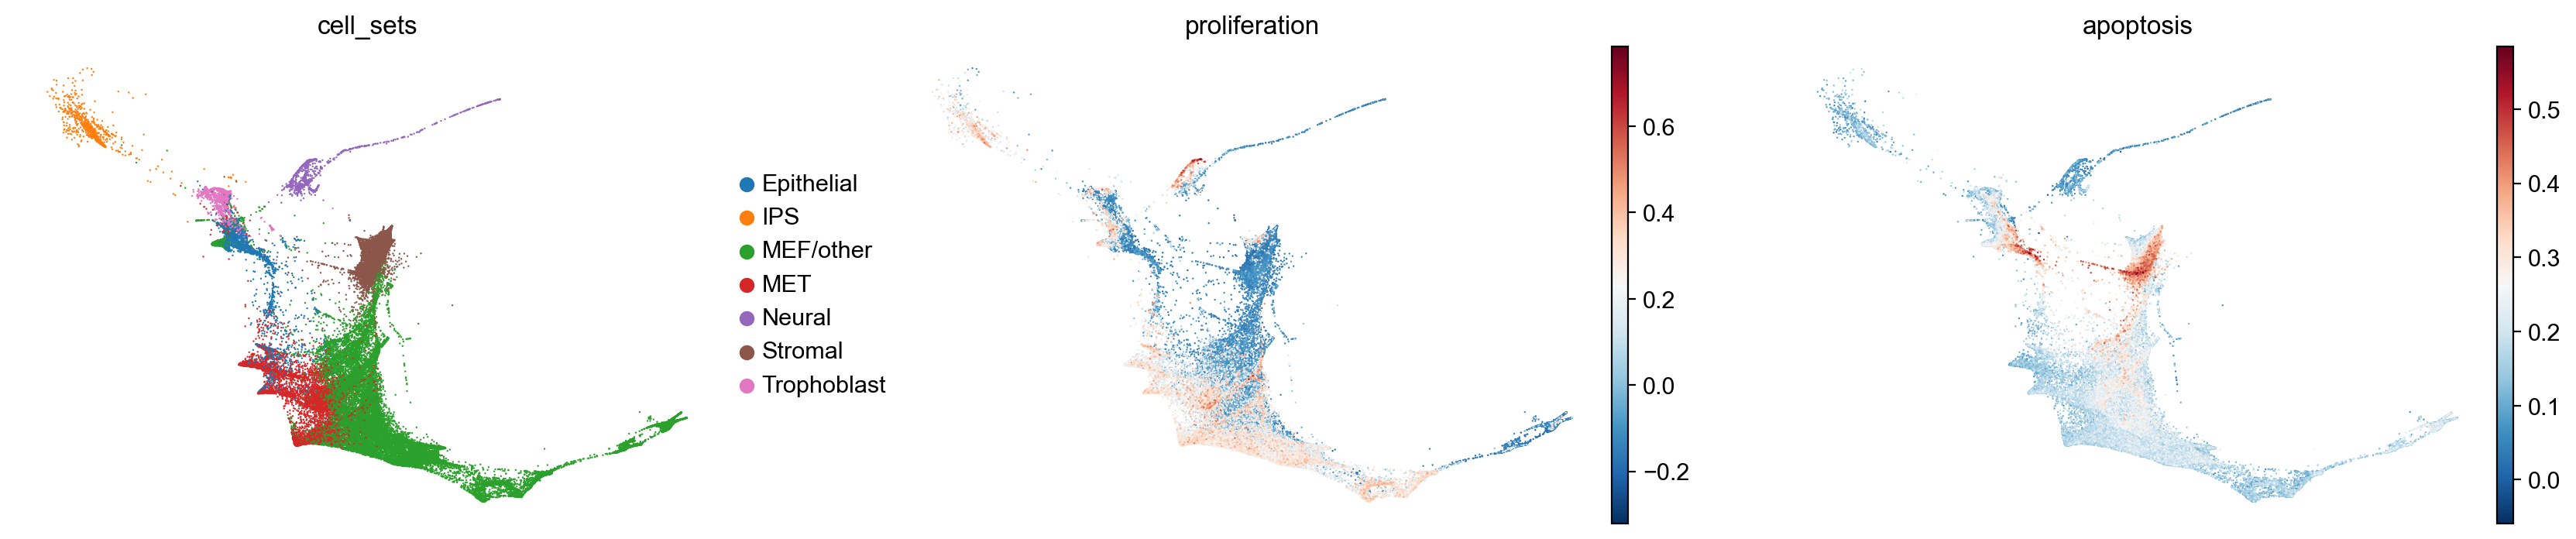

In [15]:
sc.pl.embedding(adata, basis="force_directed", color=["cell_sets", "proliferation", "apoptosis"], frameon=False)

To match cells across time points, we need a notion of distance between them. We could use the global PCA supplied with this AnnData object; however, Schiebinger et al. demonstrated in their Waddington OT paper that a local PCA, one for each pair of time points, works better in this situation, becasue the phenotypic landscape changes drastically as reprogramming proceeds (CITE). Accordingly, we prepare the `TemporalProblem` without passing a `joint_attr`, this automatically comptes local PCAs. 

In [16]:
tp = tp.prepare(time_key="day")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`       

In the final step, we solve one OT problem per time point pair, probabilistically matching early- to late cells. 

In [17]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `38` problems                                                                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(561, 489)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1785, 1756)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1620, 2118)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(755, 762)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(685, 954)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1749, 1641)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(866, 881)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(919,

In [18]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates
adata.obs["posterior_growth_rates"] = tp.posterior_growth_rates

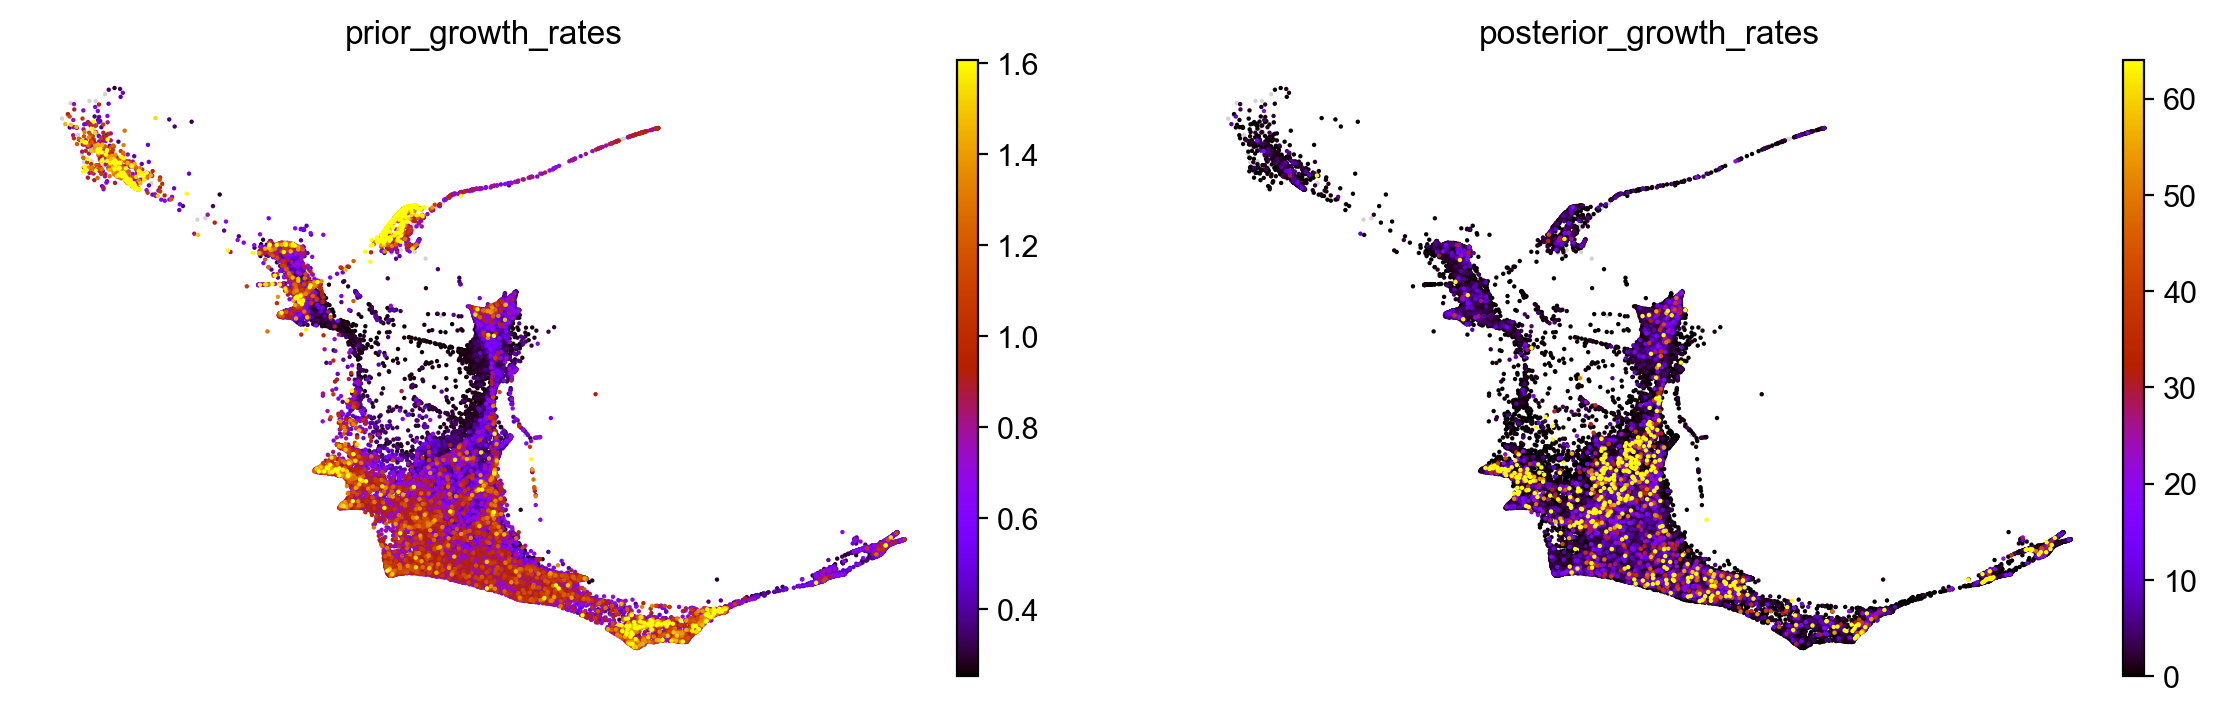

In [19]:
sc.pl.embedding(
    adata,
    basis="force_directed",
    color=["prior_growth_rates", "posterior_growth_rates"], vmax="p99", frameon=False, color_map="gnuplot", size=10
)

## Set up TransportMapKernel

In [39]:
tmk = TransportMapKernel.from_moscot(tp)

In [37]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

  0%|          | 0/38 [00:00<?, ?time pair/s]

Using automatic `threshold=0.0`


TransportMapKernel[n=41473, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `1000`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:35)
Plotting random walks


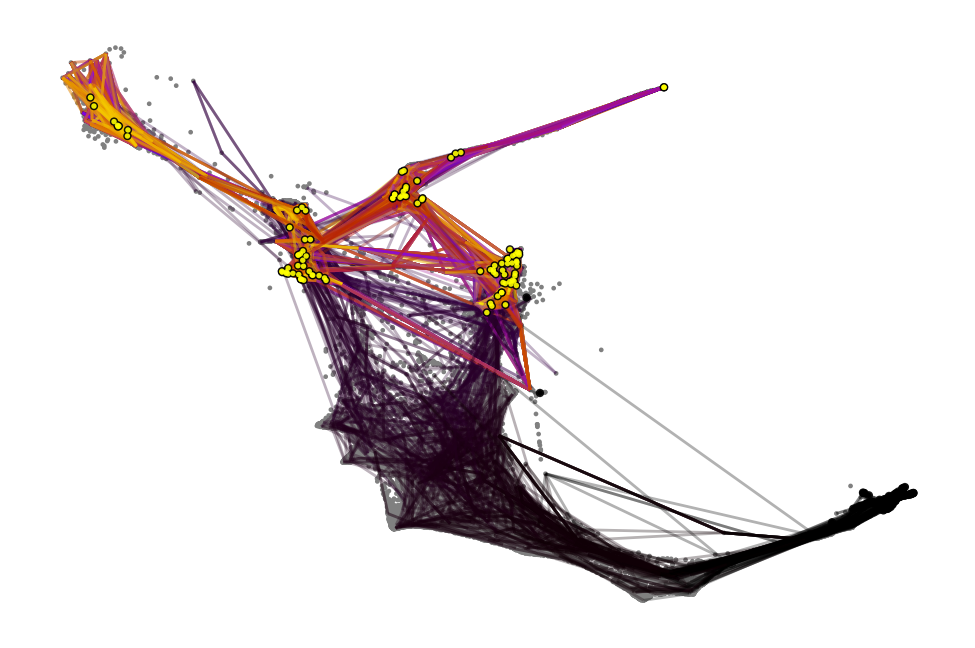

In [25]:
tmk.plot_random_walks(max_iter=1000, start_ixs={"day": 0.0}, basis="force_directed", seed=0) 

Visualize the flow of probability mass in time. 

Computing flow from `MEF/other` into `2` cluster(s) in `38` time points
Plotting flow from `MEF/other` into `2` cluster(s) in `38` time points


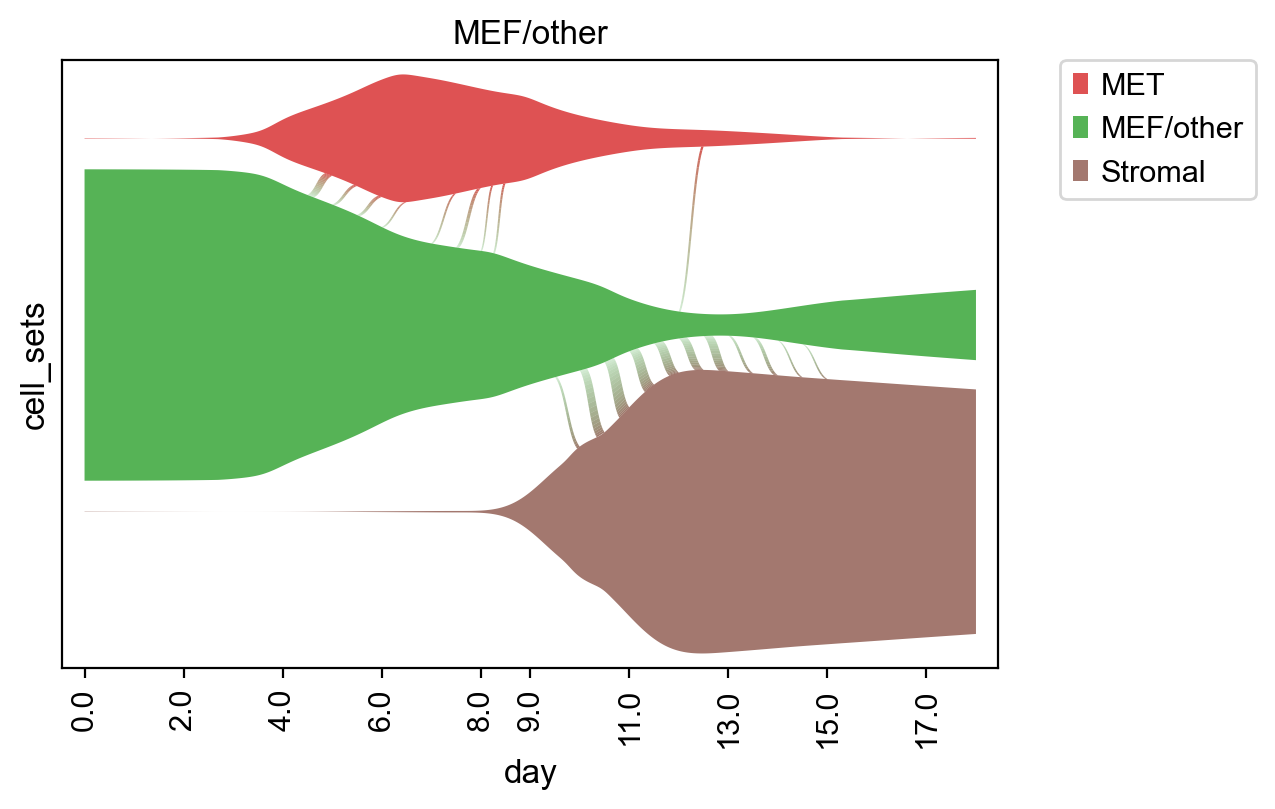

In [23]:
ax = tmk.plot_single_flow(
    cluster_key="cell_sets",
    time_key="day",
    cluster="MEF/other",
    min_flow=0.1,
    xticks_step_size=4,
    show=False,
    dpi=100,
    clusters=["MEF/other", "MET", "Stromal"],
)

# prettify the plot a bit, rotate x-axis tick labels
locs, labels = plt.xticks()
ax.set_xticks(locs)
ax.set_xticklabels(labels, rotation=90)

plt.show()

## What's next? 

In this tutorial, you learned how to visualize trajectory-specific gene expression trends via line plots or heatmaps, and how to cluster them. For the next steps, we recommend...

- trying this out with cell-transitions derived from another kernel (REF). The beautify of CellRank is that you can run the exact same computations from above, no matter what data modality you used to obtain your cell-cell transition matrix. 
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 
- trying this out on your own data. 

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). 

## Package versions

In [24]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
